This notebook is freely available for redistribution under the [GPL-3.0 license](https://choosealicense.com/licenses/gpl-3.0/).

Author: 蘇嘉冠 feabries@gmail.com

Contributors: 蘇郁翔 asdfghjkl225836@gmail.com

# 人工智慧與工程應用實作 2023 作業四 Part II

請先登入 Google 帳號並且複製一份至你的 Google Drive，將複製的那份改名為 `hw4-2_學號.ipynb`，並且用複製的那份寫作業

## 題組：糖尿病預測

這題修改自 Kaggle 的 [Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)，目的是藉由一些病人的特徵資訊，來判斷病人是否可能會得糖尿病。

訓練資料（`train.csv`） 總共有 20,000 筆病人的資料，包含以下欄位：
- `id`: 去識別化後的 ID
- `gender`: 性別，可能會是 `Male`, `Female` 或 `Other`
- `age`: 年齡
- `bmi`: BMI 值
- `blood_glucose_level`: 血液的葡萄糖含量
- `HbA1c_level`: 過去 2-3 個月的平均血糖指標（Hemoglobin A1c）
- `heart_disease`: 是否有心臟相關疾病，`0` 代表沒有，`1` 則是有
- `hypertension`: 是否有高血壓，`0` 代表沒有，`1` 則是有
- `smoking_history`: 吸煙史，可能會是 `never`, `ever`, `not current`, `former`, `current` 或 `No Info`
- `diabetes`: 是否有糖尿病，`0` 代表沒有，`1` 則是有

測試資料（`test.csv`）有 2,000 筆資料，與訓練資料不同的是缺少 `diabetes` 欄位。

你的目標是要用訓練資料來訓練模型，預測測試資料中的每個病人是否有糖尿病，並將結果儲存在 `test_pred.csv`，檔案有兩個欄位：
- `id`：測試資料中的病人 ID
- `diabetes`：你的模型預測值（`1` 或是 `0`）

我們會在用真實的答案跟你上傳的檔案（`test_pred.csv`）計算 F1 Score，並且根據 F1 Score 計算 Part II 的得分（小數點皆無條件進位）：
- 如果 F1 Score 小於 0.7，得分 = *30 * (F1_Score / 0.7)*
- 如果 F1 Score 大於等於 0.7 且 小於 0.81，得分 = *30 + 30 * ((F1_Score - 0.7) / (0.81 - 0.7))*
- 如果 F1 Score 大於等於 0.81，得分 = *60*

例如當 F1 Score 為 0.75 時，得分 = *30 + 30 * ((0.75 - 0.7) / (0.81 - 0.7)) = 44*


In [ ]:
!pip install numpy pandas matplotlib scikit-learn

In [ ]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/AINTUT/code_2023/main/datasets/"
    "diabetes_prediction/train.csv",
)

print(df)

以下幾個程式碼區塊簡單的秀出訓練資料大致的情況，需要的話你可以做更多更詳細的 EDA

In [ ]:
print(df.info())

In [ ]:
print(df.describe())

In [ ]:
import matplotlib.pyplot as plt

# Show label counting for target feature ("diabetes").
df["diabetes"].value_counts().plot(kind="bar")
plt.show()

### Data Preprocessing

讀取原始資料後，我們需要先將 input x 與 output y 根據他們需要的 feature，將資料分別取出。

In [ ]:
# Features for x.
input_features = [
    "gender",
    "age",
    "bmi",
    "blood_glucose_level",
    "HbA1c_level",
    "heart_disease",
    "hypertension",
    "smoking_history",
]
# The feature for y.
output_feature = "diabetes"

In [ ]:
import numpy as np

# Collect data values for input x.
x_data = df[input_features].copy()
y_data = df[output_feature].copy()

print(x_data.head())
print(y_data.head())
print(x_data.shape)
print(y_data.shape)

這次資料的 input feature 包含了非純數字的欄位，像是 `gender` 跟 `smoking_history`，它們是所謂的 Categorical Variable，我們需要透過一些技巧將這些 feature 數值化，一種簡單方式是做 one-hot encoding，會根據這個 feature 有幾種值，轉成幾個 1 或 0 的 feature。例如 `gender` 有 3 種值，則會轉化成為 3 個 feature，每個 feature 的值是 1 或 0。


實做上，我們可以直接使用 scikit-learn 的 [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

examples = pd.DataFrame([["Male"], ["Female"], ["Female"], ["Other"]], columns=["age"])
print("Before:")
print(examples)

examples_encoded = cat_encoder.fit_transform(examples).toarray()
print("After:")
print(examples_encoded)

為了方便將 feature 轉換用在 DataFrame 上，我們使用了 scikit-learn 的 [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)。在這裡我們先只放一個 one-hot encoding，並且只作用在 `gender` 跟 `smoking_history` 兩個 feature 上。

如果需要的話，你也可以放好幾個不同轉換 feature 的功能。

In [ ]:
from sklearn.compose import ColumnTransformer

# Categorical features.
cat_features = [
    "gender",
    "smoking_history",
]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(), cat_features),
])

雖然我們已經有測試資料了，但沒有對應的 Ground Truth，因此我們從訓練資料切出部份的驗證資料集。接下來訓練出來的模型會用驗證資料集來做 Evaluation。

驗證資料的命名，通常會用 `val` 或 `valid` 之類的字眼。

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_data,
    y_data,
    test_size=0.1,
    random_state=0,
)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

### Training

接下來準備訓練，我們一樣先用 scikit-learn 的 [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 來做分類的訓練。

跟之前練習不一樣的是，用 scikit-learn 的 [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) 將 feature 轉換（資料前處理）與模型接在一起，接下來只要操作 `classifier` 物件，就可以同時達成資料前處理與模型訓練/預測了，不用兩者分開操作。

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = LogisticRegression(
    multi_class="multinomial",
    solver="sag",
    C=1000.0,
    random_state=0,
)

classifier = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model),
])

print(classifier)

同之前的練習，只要呼叫 `.fit()` 就可以訓練你的模型。

In [ ]:
classifier.fit(x_train, y_train)

### Evaluation

直接使用 scikit-learn 的 [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) 來看各個 Metrics 的狀況。可以看到 Accuracy 為 0.92 雖然還不錯，但 label 為 1 的 Metrics 則相當不好，甚至 Precision 跟 F1 Score 都是 0.0。

In [ ]:
from sklearn.metrics import classification_report

y_pred = classifier.predict(x_val)
print(classification_report(y_val, y_pred))

如果你用 Confusion Matrix，可以看出問題是所有預測的 label 都是 0。

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat):
    plt.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)

    for idx_true in range(conf_mat.shape[0]):
        for idx_pred in range(conf_mat.shape[1]):
            plt.text(
                x=idx_pred,
                y=idx_true,
                s=conf_mat[idx_true, idx_pred],
                va="center",
                ha="center",
            )

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")

    plt.show()

# Construct the confusion matrix.
conf_mat = confusion_matrix(y_val, y_pred)

# Visualize the confusion matrix.
plot_confusion_matrix(conf_mat)

我們真正的目標是 label 為 1 的 F1 Score，定義 `eval_score()` 這個 function 來計算。接下來你的目標就是要讓這個分數越高越好

In [ ]:
from sklearn.metrics import f1_score

def eval_score(classifer, x, y):
    return f1_score(y, classifier.predict(x))

print("F1 Score on validation set:", eval_score(classifier, x_val, y_val))

### 對測試資料做預測

以下程式碼會讀取測試資料、用模型做預測，並且將預測結果存在 `test_pred.csv`。

當你覺得模型進步時，可以再執行這裡的程式碼一次，並且按下 Colab 的 `檔案` 按鈕下載檔案。圖示：
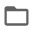

附註：除非真的需要，否則盡量不要修改這裡的程式碼

In [ ]:
df_test = pd.read_csv(
    "https://raw.githubusercontent.com/AINTUT/code_2023/main/datasets/"
    "diabetes_prediction/test.csv",
)

x_test = df_test[input_features].copy()
y_pred = classifier.predict(x_test)

df_result = pd.DataFrame({
    "id": df_test["id"],
    "diabetes": y_pred,
})
df_result.to_csv("test_pred.csv", index=False)

## 讓結果更好

現在你要試著修改上面任何的程式碼，讓你的模型預測的更好，以下提供幾個可能的方向

（但不一定每個方向都會更好喔，請多多嘗試、實驗）

除了切出固定驗征資料（目前的方法），你也可以嘗試用 Cross Validation 的方法，例如 [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

### 評估方法

你可以用驗證資料的 F1 Score 來評估你修改後的模型是否有進步。這次驗證資料的分數大概會比測試資料高 0.01 ~ 0.03 左右，例如驗證資料的 F1 Score 為 0.75 的話，測試資料的 F1 Score 大概會落在 0.72 到 0.74 之間

### Data Preprocessing

可以先嘗試這兩個方向，對結果會有相當好的改進：
1. `heart_disease` 跟 `hypertension` 這兩個 feature 的值不是 0 就是 1，也可以算做 Categorical Variable，試著讓它們一起加入 one-hot encoding 的對象
2. 對於不屬於 Categorical Variable 的 feature，可以做 Feature Scaling，例如 Standardization 或 Normalization

對於 Categorical Variable，如果你想要嘗試 one-hot encoding 之外的方法，可以參考[這篇文章](https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/)，實做可以使用 [Category Encoders](https://contrib.scikit-learn.org/category_encoders/)（需要透過 `pip` 安裝套件）

如果你想嘗試 Feature Selection，可以看一下 scikit learn 的[文件](https://scikit-learn.org/stable/modules/feature_selection.html)

### Hyperparameter Tuning

你可以嘗試各種不同 hyperparameter，例如將 LogisticRegression 的 `C=1000.0` 改成 `C=100.0`，看一下結果會不會更好。

如果你想要嘗試各種 hyperparameter 不同的組合，可以試著用 scikit-learn 的 [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)，以下範例是對 LogisticRegression 的 2 x 2 = 4 種組合的 hyperparameter 中，找出最好的一組：
- `C=100.0, penalty="l2"`
- `C=100.0, penalty=None`
- `C=1000.0, penalty="l2"`
- `C=1000.0, penalty=None`



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

param_grid = {
    "C": [100.0, 1000.0],
    "penalty": ["l2", None],
}

grid_model = GridSearchCV(
    LogisticRegression(multi_class="multinomial", solver="sag", random_state=0),
    param_grid=param_grid,
)
grid_classifier = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", grid_model),
])

grid_classifier.fit(x_train, y_train)
grid_classifier.predict(x_val[:10])

至於怎麼定義"最好"，你可能需要看一下 GridSearchCV 的說明文件，去調整它的參數，例如 `scoring` 跟 `cv`。

### 選用不同的分類器（Classifier）

除了 LogisticRegression，你也可以選用不同的分類器。

scikit-learn 內建許多分類器，常用的幾種包含：
- KNN
- Neural Networks (MLP)
- Bagging
- Random Forest
- AdaBoost
- Gradient Boosting
- Voting

其他常見的套件，需要透過 `pip` 安裝，使用方法跟 scikit-learn 幾乎一樣：
- [xgboost](https://xgboost.readthedocs.io/en/stable/)
- [catboost](https://catboost.ai/)
- [lightgbm](https://lightgbm.readthedocs.io/en/v3.3.2/index.html)


下面以 KNN 為分類器的範例

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier()
knn_classifier = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", knn_model),
])

knn_classifier.fit(x_train, y_train)
knn_classifier.predict(x_val[:10])

### Imbalanced Data

這次的資料算是 imbalanced data（output label 的 0 跟多、1 很少），有些技術對處理這種資料可能有幫助，最常見的是 [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

### 參考別人的方法

你也可以直接去 Kaggle 看別人嘗試過的方法，例如這次的原始資料來源：[Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)，點進連結後再按 `Code`，可以看到很多程式碼

類似的資料集/比賽也很值得參考，例如 [Binary Classification with a Tabular Stroke Prediction Dataset](https://www.kaggle.com/competitions/playground-series-s3e2) 。